In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set plot style for professional looking figures
plt.style.use('seaborn-v0_8-whitegrid')

In [12]:
# Load the dataset
# Ensure 'M2SL.csv' is in your working directory or adjust the path
df = pd.read_csv('../data/raw/M2SL.csv')

# Convert date column to datetime objects and set as index
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)

# Rename column for clarity
df.rename(columns={'M2SL': 'M2'}, inplace=True)

# Display first few rows
print("First 5 rows of the raw data:")
print(df.head())

First 5 rows of the raw data:
                     M2
observation_date       
1959-01-01        286.6
1959-02-01        287.7
1959-03-01        289.2
1959-04-01        290.1
1959-05-01        292.2


In [ ]:
# Create target variable: Monthly Growth Rate (Log-Difference)
# Multiplied by 100 to express as percentage
df['M2_Growth'] = np.log(df['M2']).diff() * 100

# Remove the first NaN value created by differencing
df_clean = df.dropna()

print(f"Original dataset size: {len(df)} observations")
print(f"Transformed dataset size: {len(df_clean)} observations")

Original dataset size: 802 observations
Transformed dataset size: 801 observations


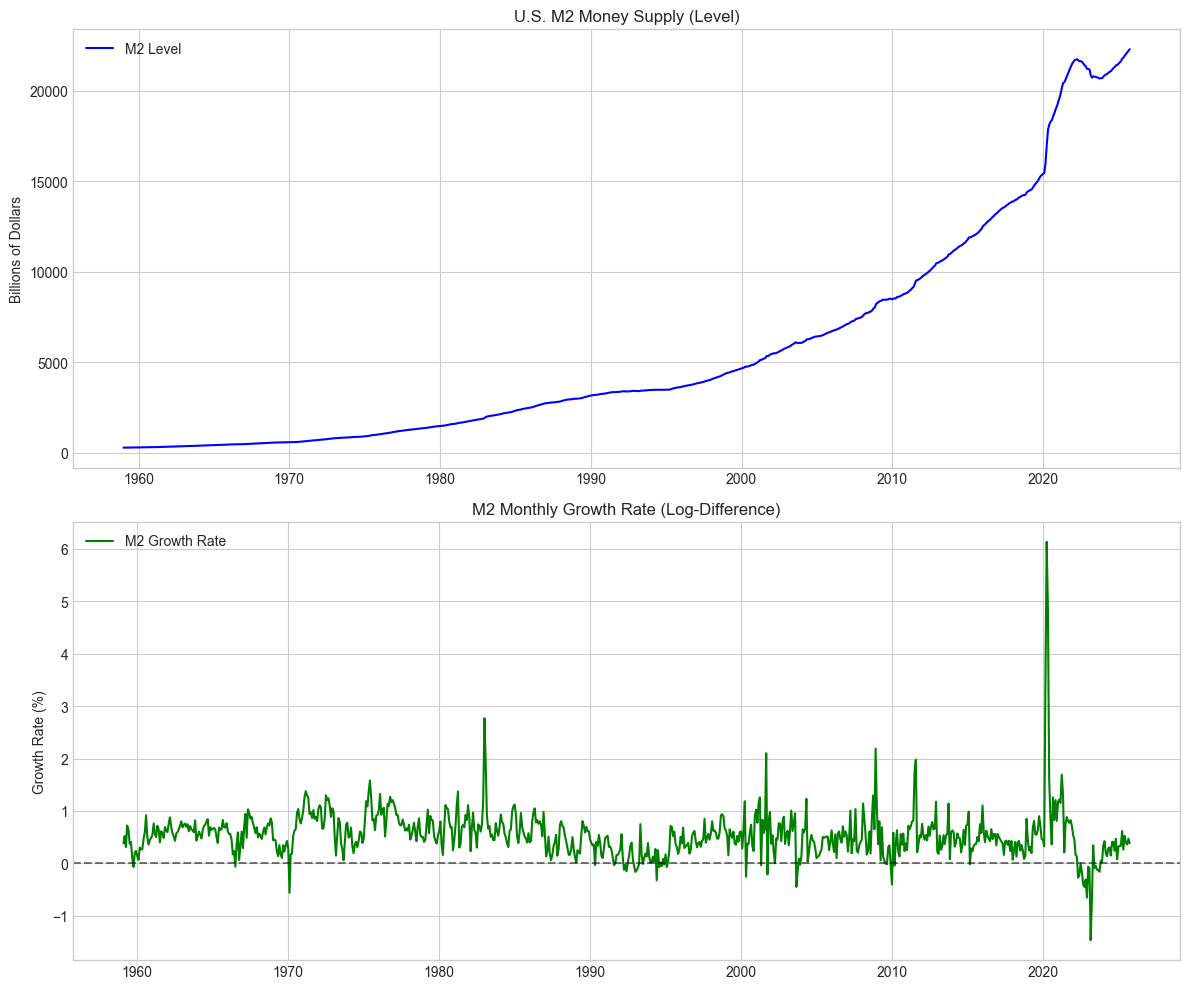

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: M2 Level (Non-stationary)
axes[0].plot(df['M2'], color='blue', label='M2 Level')
axes[0].set_title('U.S. M2 Money Supply (Level)')
axes[0].set_ylabel('Billions of Dollars')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Growth Rate (Stationary)
axes[1].plot(df_clean['M2_Growth'], color='green', label='M2 Growth Rate')
axes[1].set_title('M2 Monthly Growth Rate (Log-Difference)')
axes[1].set_ylabel('Growth Rate (%)')
axes[1].axhline(0, color='black', linestyle='--', alpha=0.5) # Zero line
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
# Optional: save the figure
# plt.savefig('m2_transformation.png', dpi=300)
plt.show()

In [16]:
print("Augmented Dickey-Fuller Test on M2 Growth Rate:")
print("-" * 50)

result = adfuller(df_clean['M2_Growth'])

print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.8f}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.4f}')

if result[1] < 0.05:
    print("\nCONCLUSION: The series is STATIONARY (Reject H0). Proceed with modeling.")
else:
    print("\nCONCLUSION: The series is NOT stationary. Further differencing needed.")

Augmented Dickey-Fuller Test on M2 Growth Rate:
--------------------------------------------------
ADF Statistic: -5.4891
p-value: 0.00000220
Critical Values:
	1%: -3.4386
	5%: -2.8652
	10%: -2.5687

CONCLUSION: The series is STATIONARY (Reject H0). Proceed with modeling.


Training Set: 1959-02-01 to 2012-06-01 (641 obs.)
Test Set:     2012-07-01 to 2025-10-01 (160 obs.)


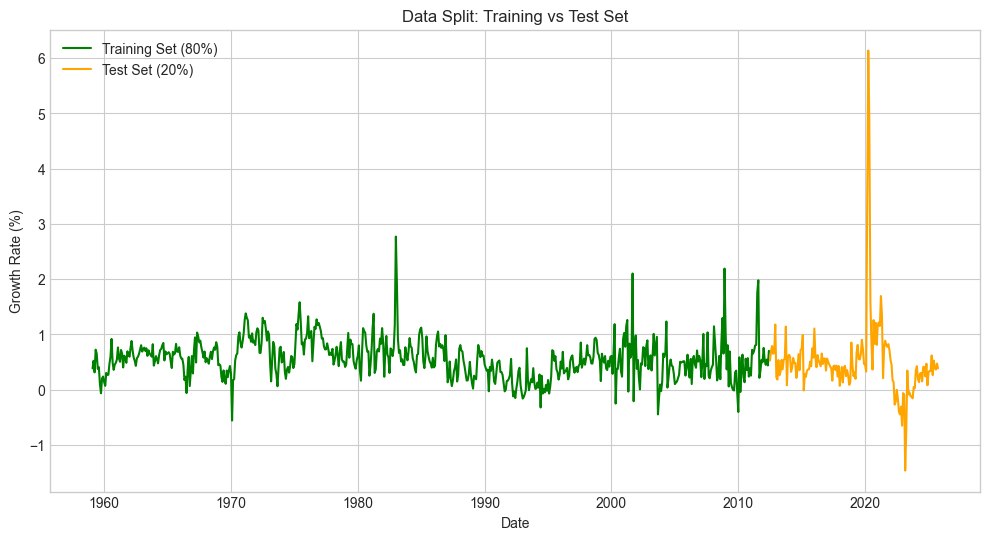

In [17]:
# Calculate split index for 80% Train / 20% Test
n_obs = len(df_clean)
n_test = int(n_obs * 0.2)
n_train = n_obs - n_test

# Split the data
train = df_clean.iloc[:n_train]
test = df_clean.iloc[n_train:]

print(f"Training Set: {train.index.min().date()} to {train.index.max().date()} ({len(train)} obs.)")
print(f"Test Set:     {test.index.min().date()} to {test.index.max().date()} ({len(test)} obs.)")

# Plot the split
plt.figure(figsize=(12, 6))
plt.plot(train['M2_Growth'], label='Training Set (80%)', color='green')
plt.plot(test['M2_Growth'], label='Test Set (20%)', color='orange')
plt.title('Data Split: Training vs Test Set')
plt.xlabel('Date')
plt.ylabel('Growth Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

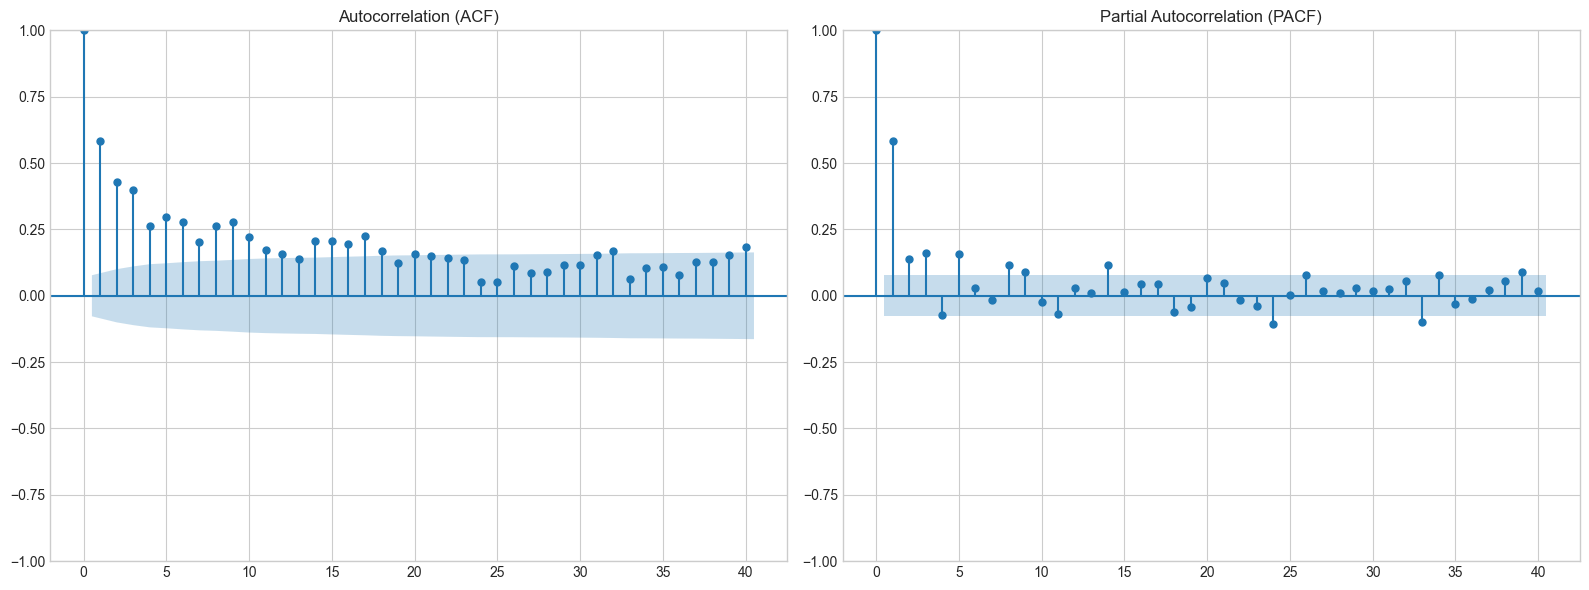

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Autocorrelation (ACF) -> Helps select MA(q) terms
plot_acf(train['M2_Growth'], lags=40, ax=axes[0], title='Autocorrelation (ACF)')

# Partial Autocorrelation (PACF) -> Helps select AR(p) terms
plot_pacf(train['M2_Growth'], lags=40, ax=axes[1], title='Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()